# Задача 1

Итак, что нужно сделать: у нас есть данные АА-теста с '2022-04-17' по '2022-04-23'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

In [1]:
import pandas as pd
from read_db.CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
sns.set(style ='ticks')
import hashlib
from scipy import stats
import numpy as np
from tqdm.auto import tqdm
#import swifter

In [2]:
df = Getch(
    '''
    select exp_group
            ,user_id
            ,sum(action='like') as likes
            ,sum(action='view') as views
            ,likes/views as ctr
    from simulator_20220520.feed_actions 
    where toDate(time) between '2022-04-17' and '2022-04-23'
        and exp_group in (2,3)
    group by exp_group, user_id
    '''
    ).df

In [3]:
df.groupby('exp_group',as_index =False).agg({'user_id':'count'}) # группы примерно одинакового размера

,exp_group,user_id
0,2,8480
1,3,8569


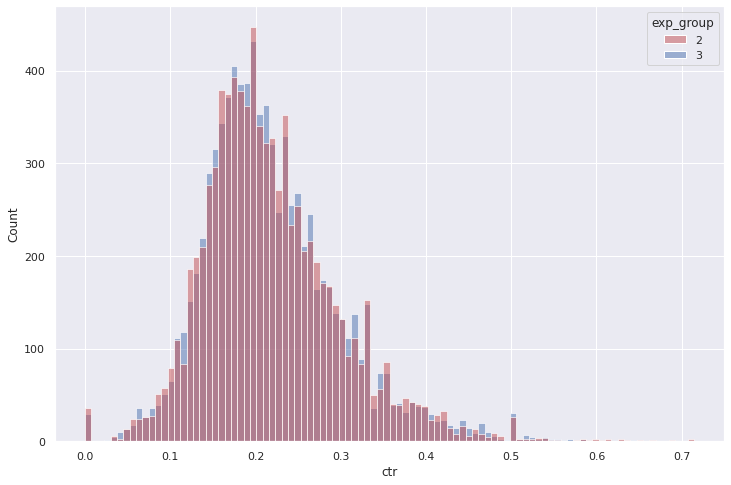

In [4]:
# На глаз наши группы как будто бы одинаковые
sns.set(rc={'figure.figsize':(12,8)})
groups = sns.histplot(data =df
                     ,x='ctr'
                     ,hue='exp_group'
                     ,palette = ['r','b']
                     ,alpha=0.5
                     ,kde=False)

1.Построить гистограмму распределения получившихся 10000 p-values.

In [18]:
# симуляция подвыборок
n = df.shape[0]
simulation = 10000
sample = 500
tests = []

for i in range(simulation):
    s1 = df[df.exp_group == 2].ctr.sample(sample, replace = False)
    s2 = df[df.exp_group == 3].ctr.sample(sample, replace = False)
    tests.append(stats.ttest_ind(s1,s2,equal_var = False)[1])

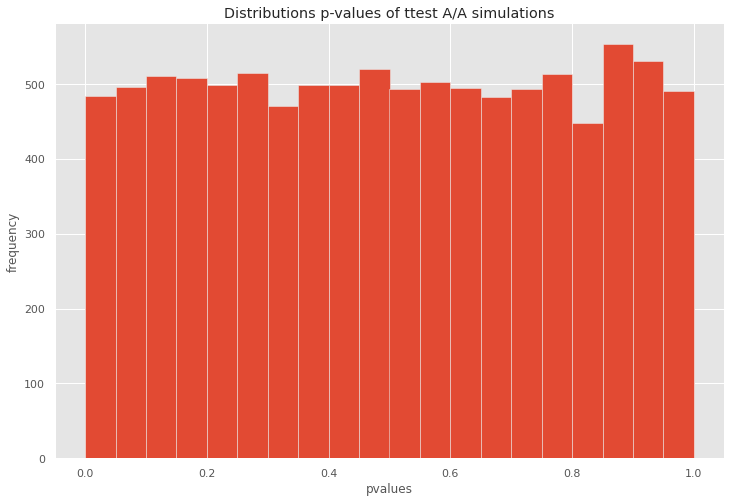

In [19]:
#рисуем распределение
plt.hist(tests,bins=20)
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Distributions p-values of ttest A/A simulations")
plt.show()
#sns.distplot(tests, kde = False)

2.Посчитать, какой процент p values оказался меньше либо равен 0.05

In [20]:
sum = 0
for i in tests:
    if i <=0.05:
        sum+=1
print(sum, 'p-values из',len(tests),'оказалось меньше либо равен 0.05',
     'Это',sum/len(tests)*100,'%')

483 p-values из 10000 оказалось меньше либо равен 0.05 Это 4.83 %


3.Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

Наша система сплитования работает корректно, так как всего 4.74% p-value из сделанных выборок меньше или равно a (0,05). Показатель ложноположительных оценок находится ниже его границы. Т.е. наши тестовые группы одинаковые и можно проводить на них ABтест.